# Computing the Mandelbrot set with Python, Cython and C

The Mandelbrot set is defined as the set of complex numbers $c$ that does not diverge when iterated from $z = 0$ for the function

\begin{align}
    f_c(z) = z^2 + c.
\end{align}

By choosing a value for $c$ and starting with $z = 0$ we can check if the sequence

\begin{align}
    z_{n + 1} = z_{n} + c,
\end{align}

diverges. In our case we do this by checking if

\begin{align}
    \lim_{n \to \infty} |z_{n + 1}| \leq d,
\end{align}

for a given divergence criteria $d$. Due to the finiteness of life, the universe and everything, we limit $n$ by a given number and abort the sequence when $|z_{n + 1}| > d$.

In [7]:
# This line might be needed by some
#%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

In [2]:
%%javascript
// Fill entire cell with output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [8]:
# Adjust the figure size of matplotlib
figsize(20, 14)
# Use Latex rendering of axes
plt.rc('text', usetex=True)

In [9]:
# Define variables for an interesting region of the Mandelbrot set
x_min = -0.835
x_max = -0.830
y_min = 0.209
y_max = 0.211
num_x = 2000
num_y = 2000
#max_iterations = 100
max_iterations = 1000
divergence = 2

In [10]:
# Run the C-code of the Mandelbrot set
from compute_mandelbrot import get_mandelbrot_set
mandelbrot_set = get_mandelbrot_set(x_min, x_max, y_min, y_max, num_x, num_y, max_iterations, divergence)

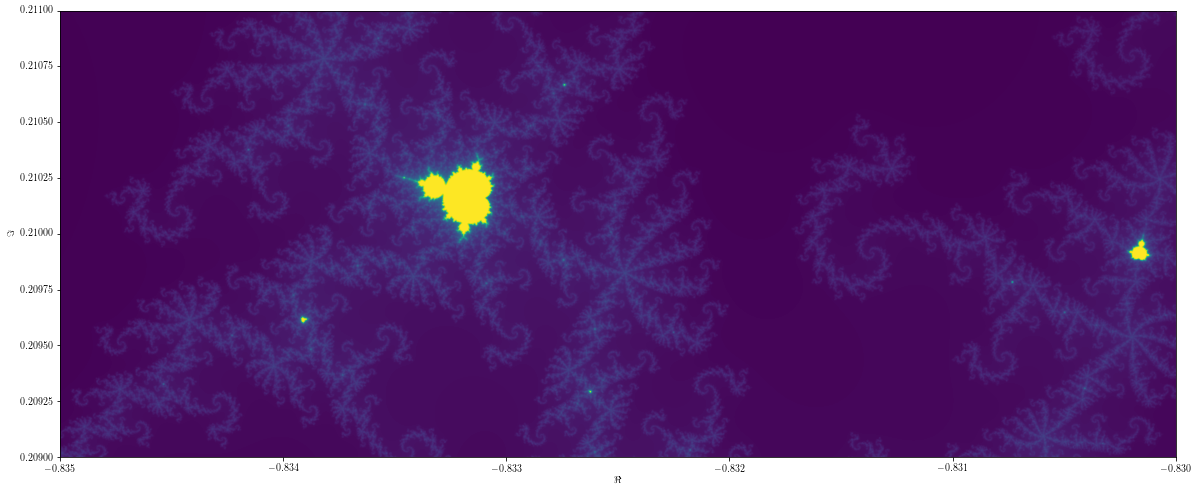

In [11]:
plt.imshow(
    mandelbrot_set, extent=[x_min, x_max, y_min, y_max], origin="lower", interpolation="bicubic")
plt.xlabel(r"$\Re$")
plt.ylabel(r"$\Im$")
plt.show()